# Train on Our Data

In [1]:
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import yaml

from data_loader import BinClassifierDataModule
from model.ddim import Classifier
from trainer import Trainer

In [2]:
# relevant for vs code
import matplotlib
matplotlib.use('Qt5Agg')
%matplotlib inline

## Load the config

In [3]:
with open('./configs/ddim_config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Reproducibility
pl.seed_everything(config['seed'])

Seed set to 42


42

## Load Data for Classification and Visualize

Using 249 normal images and 83 images with pathologies for training. Using 30 images for validation.
Batch shape: torch.Size([32, 1, 64, 64])
Batch min: 0.0
Batch max: 1.0


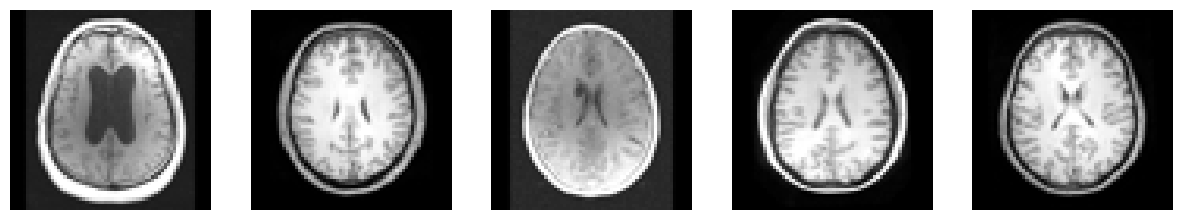

In [4]:
train_data_module = BinClassifierDataModule(
    split_dir=config['split_dir'],
    target_size=config['target_size'],
    batch_size=config['batch_size'])

# Plot some images
batch = next(iter(train_data_module.train_dataloader()))
bt_im = batch["image"]

# Print statistics
print(f"Batch shape: {bt_im.shape}")
print(f"Batch min: {bt_im.min()}")
print(f"Batch max: {bt_im.max()}")

fig, ax = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    ax[i].imshow(bt_im[i].squeeze(), cmap='gray')
    ax[i].axis('off')
plt.show()

In [5]:
# # Plot some images
# batch = next(iter(train_data_module.val_dataloader()))
# bt_im = batch["image"]
# bt_lab = batch["slice_label"]

# normal_im = bt_im[bt_lab == 0]
# abnormal_im = bt_im[bt_lab == 1]

# n = max(len(normal_im), len(abnormal_im))
# print(n)

# fig, ax = plt.subplots(2, n, figsize=(20, 5))
# for i, im in enumerate(normal_im):
#     ax[0][i].imshow(im.squeeze(), cmap='gray')
#     ax[0][i].axis('off')
# for i, im in enumerate(abnormal_im):
#     ax[1][i].imshow(im.squeeze(), cmap='gray')
#     ax[1][i].axis('off')
# plt.show()

# model = Classifier(config)
# pred = model(bt_im.to(model.device), timesteps=torch.randint(0, 1000, (len(bt_im),)).to(model.device))
# torch.nn.functional.cross_entropy(pred, bt_lab.to(model.device).long())

## Tensorboard

In [6]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6009 (pid 14724), started 4 days, 1:28:55 ago. (Use '!kill 14724' to kill it.)

## Prepare model

In [7]:
# Init DDIM model
model = Classifier(config)

# Init trainer
trainer = Trainer(
    max_epochs=config['num_epochs_cls'],
    log_dir=config['classifier_log_dir'],
    # early_stopping=config['early_stopping'],
)

## Run training

In [8]:
# Train the model ⚡
model = trainer.fit(model, datamodule=train_data_module)

# save last model weights
torch.save(model.state_dict(), f"{config['classifier_log_dir']}/last_weights.pth")

Epoch: 999, loss: 0.1917, val_loss: 15.0879: 100%|██████████| 1000/1000 [19:05<00:00,  1.15s/it]


In [ ]:
assert False, "Stop here"

# Train on Decathlon Dataset

the previous method is somehow cheating since we analyze and evaluate the performance of the method (DDIM with CG) with the same data we use for training the classifier.\
This is why we decided to train the classifier also on the Decathlon Dataset. This is the same dataset they used in the paper. 

In [1]:
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import yaml
from torch.utils.data import DataLoader

from model.ddim import Classifier
from trainer import Trainer

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from monai.apps import DecathlonDataset
from monai import transforms

In [2]:
with open('./configs/ddim_config.yaml', 'r') as f:
    config = yaml.safe_load(f)

pl.seed_everything(config['seed'])  # Reproducibility

Seed set to 42


42

## Load the Data

Make sure you have enough disk space to download the dataset (about 4-5GB).

In [3]:
home_dir = os.path.expanduser('~')
root_dir = os.path.join(home_dir, 'Downloads', 'datasets')
assert os.path.exists(root_dir), f'root_dir {root_dir} does not exist'
# 

In [4]:
channel = 0  # 0 = Flair
assert channel in [0, 1, 2, 3], "Choose a valid channel"

train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.EnsureChannelFirstd(keys=["image", "label"]),
        transforms.Lambdad(keys=["image"], func=lambda x: x[channel, :, :, :]),
        transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        transforms.EnsureTyped(keys=["image", "label"]),
        transforms.Orientationd(keys=["image", "label"], axcodes="RAS"),
        transforms.Rotate90d(keys=["image", "label"], k=1, spatial_axes=(0, 1)),  # align orientation with our dataset
        transforms.Spacingd(keys=["image", "label"], pixdim=(3.0, 3.0, 2.0), mode=("bilinear", "nearest")),
        transforms.CenterSpatialCropd(keys=["image", "label"], roi_size=(64, 64, 44)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1, relative=True),
        transforms.RandSpatialCropd(keys=["image", "label"], roi_size=(64, 64, 1), random_size=False),
        transforms.Lambdad(keys=["image", "label"], func=lambda x: x.squeeze(-1)),
        transforms.CopyItemsd(keys=["label"], times=1, names=["slice_label"]),
        transforms.Lambdad(keys=["slice_label"], func=lambda x: 0.0 if x.sum() > 0 else 1.0),
    ]
)

batch_size = config['batch_size']

In [5]:
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="training",
    cache_rate=3.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=False,  # Set download to True if the dataset hasnt been downloaded yet
    seed=0,
    transform=train_transforms,
)

print(f"Length of training data: {len(train_ds)}")  # this gives the number of patients in the training set
print(f'Train image shape {train_ds[0]["image"].shape}')

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)

Loading dataset:   0%|          | 0/388 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 388/388 [03:52<00:00,  1.67it/s]

Length of training data: 388
Train image shape torch.Size([1, 64, 64])


In [6]:
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="validation",
    cache_rate=3.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=False,  # Set download to True if the dataset hasnt been downloaded yet
    seed=0,
    transform=train_transforms,
)
print(f"Length of training data: {len(val_ds)}")
print(f'Validation Image shape {val_ds[0]["image"].shape}')

val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=True)

Loading dataset:   0%|          | 0/96 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 96/96 [00:57<00:00,  1.67it/s]

Length of training data: 96
Validation Image shape torch.Size([1, 64, 64])


## Visualize the Data

Batch shape: torch.Size([8, 1, 64, 64])
Batch min: 0.0
Batch max: 1.8932639360427856


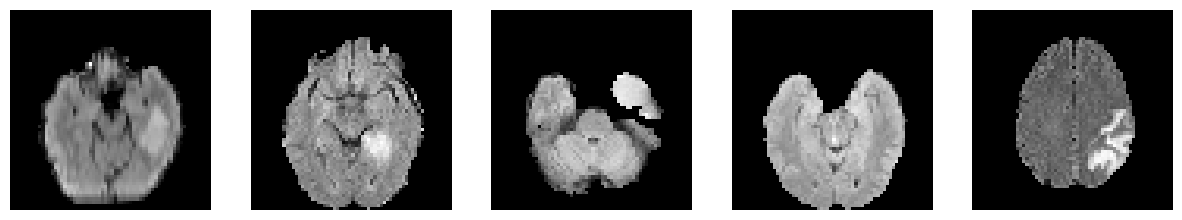

In [7]:
# Plot some images
btch = next(iter(train_loader))
batch = btch['image']

# Print statistics
print(f"Batch shape: {batch.shape}")
print(f"Batch min: {batch.min()}")
print(f"Batch max: {batch.max()}")

fig, ax = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    ax[i].imshow(batch[i].squeeze(), cmap='gray')
    ax[i].axis('off')
plt.show()

As you can see the data distribution varies a lot from our data. It is to see if the classifier can generalize enough to produce meaningful image-gradients for our data. 

## Tensorboard

In [8]:
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs/

## Prepare Model

In [9]:
# Init DDIM model
model = Classifier(config)

# Init trainer
trainer = Trainer(
    max_epochs=config['num_epochs_cls'],
    log_dir=config['classifier_dec_log_dir'],
    early_stopping=config['early_stopping'],
)

## Run Training

In [10]:
# Train the model ⚡
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

Epoch: 111, loss: 0.5088, val_loss: 0.2548:  11%|█         | 112/1000 [07:01<55:44,  3.77s/it]

Early stopping at epoch 112


Classifier(
  (classifier): DiffusionModelEncoder(
    (conv_in): Convolution(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (time_embed): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock(
        (resnets): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 32, eps=1e-06, affine=True)
            (nonlinearity): SiLU()
            (conv1): Convolution(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
            (norm2): GroupNorm(32, 32, eps=1e-06, affine=True)
            (conv2): Convolution(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (skip_connection)